In [43]:
import pandas as pd
from mdl_scorer import MDL_Scorer
from network import network
import matplotlib.pyplot as plt
import numpy as np
from ep import EP
import algo_tools
import random
from IPython.display import Image
from numpy.random import choice
from aep import AEP

# Learning Bayesian Networks with Evolutionary Programming

# Motivation

<font color="blue">
Evolutionary programming works to solve this problem to find a simple network that accurately models the data. Throughout this report we will be using a dataset of Diabetes patients. 
    
### What problem am I solving?
The main issue with Bayesian Networks is that there are too many options of causal relationships. Unless you are an expert on the specific set of data, it is challenging to support your proposed network. I am exploring a systematic way to find a reliable Bayesian Network without needing to manually consider the individual attributes of the data.

### Why Is this interesting?
This is interesting for multiple reasons. First, I have been interested in the concept of evolutionary programming for some time (through reading and watching online resources). However, I haven't had the chance to practice it at all. This gives me the opportunity to explore this technique. Furthermore, I am curious to see how a program can learn relationships between attributes without necessarily knowing what that attribute's name means. In otherwords, while it is intuitive that the words age and pregnancies are correlated, how does a program learn this without knowing the meanings of the words?

### Define Success
The ideal definition of success in this case would be if the algorithm produces a network that is exactly what I would expect. For example, in the alarm example, the perfect network would look exactly like the one that was originally given to us. However, a more realistic version of success would be one such that the algorithm is producing a network that at least makes intuitive sense rather than one that looks like it was randomly generated. Throughout this project, I worked to prove that the networks did have some logic behind them and that they were not randomly produced.

In [44]:
diabetes = pd.read_csv('diabetes.csv')
columns = list(diabetes.columns)
columns[-1] = "Diabetes"
diabetes.columns = columns
scorer = MDL_Scorer(diabetes)
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# 1. Intro to MDL. It Prefers Simpler Models

<font color="blue">
Before starting evolutionary programming, we need a way to compare Bayes Nets to each other.

We can consider the probability that a network properly models the data. Intuitively this probability should factor in the complexity of the network as well as how well it models the data. Let's look at the minimum description length (MDL) score.

## 1.1 MDL Equation

<font color="blue">

Let 
* D = data
* h = hypothesis (the Bayes Net in this case)
* HuffSize(x) = The size of the Huffman encoding of X

The MDL is the maximum probability that this is the correct hypothesis for the data. More formally it is Pr(h|D)



**MDL = argmax$_h$ Pr(h|D)**

We can then recognize that this probability is a posterior. Thus, let's look at the likelihood and the prior (not normalized). 


**MDL = argmax$_h$ Likelihood * Prior**
**MDL = argmax$_h$ P(D|h) * P(h)**

Next, we can take the log$_2$ of these probabilities. Through log rules we need to add the terms instead of multiply them. Since we are taking the argmax this will not change the final relative answer

**MDL = argmin$_h$ [log$_2$ P(D|h) + log$_2$ P(h)]**

Let's now multiply the logs by -1. Since we are substracting the logs instead of adding them, we will need to swap the argmax for an argmin. This leads us with

**MDL = argmin$_h$ [- log$_2$ P(D|h) - log$_2$ P(h)]**

Through Information Theory we recognize that -log$_2$P(.) = Optimal Code Length. Thus,

**MDL = argmin$_h$ [length(D|h) + length(h)]**

What we see is that the MDL has a term with the length of the network length(h). We also see that we use the term length(D|h). This is the length of the data given the hypothesis. In simpler terms, this is the length of the data encoded with the probability distributions of the network. Specifically, these terms use the Huffman encoding. Thus

**MDL = argmin$_h$ [HuffSize(Data using network probabilities)  + HuffSize(network) ]**

## 1.2 Simple Networks Lead to Small MDL Scores

<font color="blue">
First, in the equation derivation we stated that simpler networks have smaller MDL scores. Let's confirm this by running a small experiment. We will simply plot networks in order of increasing complexity and we will plot their corresponding MDL scores

In [45]:
def simple_to_complex_example():
    matrix = algo_tools.create_blank_matrix(len(list(diabetes.columns)))
    n = network(matrix, diabetes.columns)
    scores = []
    networks = []
        
    for i in range(int(len(diabetes.columns))):
        if i % 2 == 0:
            for j in range(int(len(diabetes.columns))):
                if j % 2 == 0:
                    if i != j:
                        matrix[i][j] = 1
                        n = network(matrix, diabetes.columns)
                    networks.append(n)
                    scores.append(scorer.score(n))
    return {'networks': networks, 'scores': scores}
        
results = simple_to_complex_example()

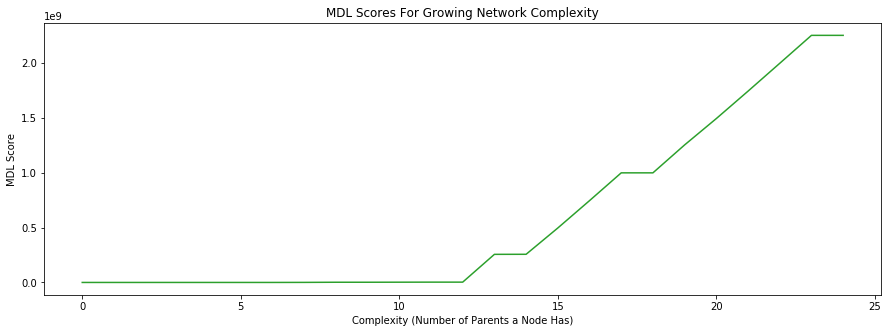

In [47]:
x = list(range(len(results['scores'])))
y = results['scores']

fig, axs = plt.subplots(figsize=(15,5))
plt.plot(x, y, color="tab:green")
plt.ylabel('MDL Score') 
plt.xlabel('Complexity (Number of Parents a Node Has)')
plt.title("MDL Scores For Growing Network Complexity")
plt.show()

<font color="blue">
What we notice is that this does indeed fit our theory that simpler networks do have smaller MDL scores. Notice that the first 10 networks have such small scores compared to the last few networks. Let's zoom in on these first few networks

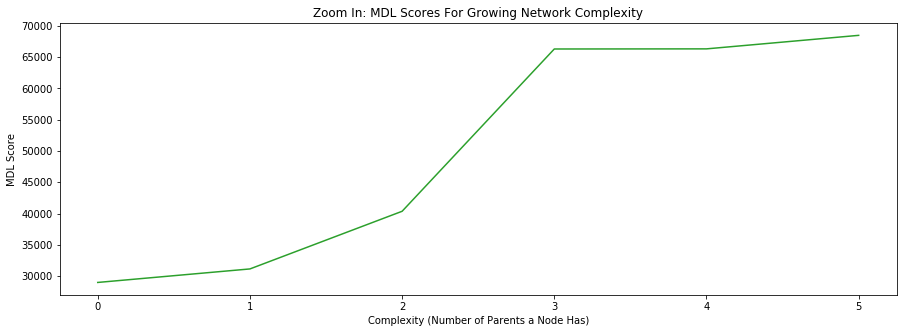

In [48]:
x = list(range(len(results['scores'][:6])))
y = results['scores'][:6]

fig, axs = plt.subplots(figsize=(15,5))
plt.plot(x, y, color="tab:green")
plt.ylabel('MDL Score') 
plt.xlabel('Complexity (Number of Parents a Node Has)')
plt.title("Zoom In: MDL Scores For Growing Network Complexity")
plt.show()

<font color="blue">
From the zoomed out view, it almost looked as if there was no change at all. This zoomed in view gives us a reality check that there is actually an increase in MDL score. Secondly, we notice that first network (which has no edgese) does have an MDL score. This shows us that even the simplest of network has a score and that MDL scores do not calibrate to 0. This is just something to take note of moving forward

<font color="blue">
Next, let's actually take a look at the networks to confirm that they have increasing complexity. 

Simple Structure


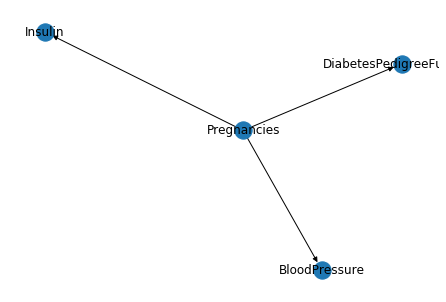

Medium Structure


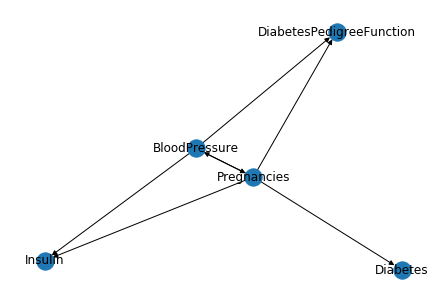

Complex Structure


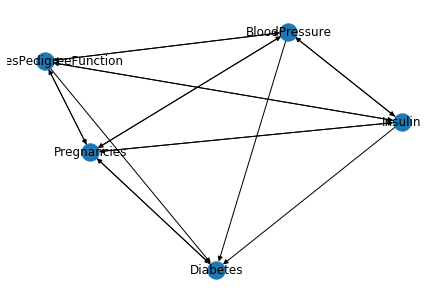

In [24]:
print("Simple Structure")
results['networks'][3].draw()

print("Medium Structure")
results['networks'][8].draw()

print("Complex Structure")
results['networks'][20].draw()

<font color="blue">
Out of these three networks, the simplest network in this example, each node had only one parent. This lead to the smallest MDL score of the three. As the networks increased from simpler to medium to complex structures, the MDL scores increased as well

## 1.3 MDL Prefers To Fit the Data

<font color="blue">
In the derivation of the MDL equation we stated two factors of MDL. These were the complexity of the network and how well the network fits the data. In section 1.2 we analyzed the former of these terms. In this section we will analyze the latter. That is, do networks that fit the data have better (lower) MDL scores?

In [3]:
def find_new_edge(matrix, last_node1, last_node2):
    node1 = last_node1
    node2 = last_node2
    
    if bool(random.getrandbits(1)):
        while matrix[node1][node2] == 1 or node1 == node2:
            if bool(random.getrandbits(1)):
                node1 = (node1 + 1) % len(matrix)
            else:
                node1 = (node1 - 1) % len(matrix)
    else:
        while matrix[node1][node2] == 1 or node1 == node2:
            if bool(random.getrandbits(1)):
                node2 = (node2 + 1) % len(matrix)
            else:
                node2 = (node2 - 1) % len(matrix)

    matrix[node1][node2] = 1
    return matrix, node1, node2

In [12]:
def same_sized_networks_example(num_edges):
    # create a population with equal number of edges
    width = len(list(diabetes.columns))
    array_model = np.zeros(width ** 2)
    matrix = array_model.reshape((width, width))
    
    pop_size = 5
    
    population = []
    scores = []
    for i in range(pop_size):
        print(i)
        new_matrix = matrix.copy()
        last_node1 = 0
        last_node2 = 0
        for j in range(num_edges):
            new_matrix, last_node1, last_node2 = find_new_edge(new_matrix, last_node1, last_node2)
        print("created", i)
        n = network(new_matrix, diabetes.columns)
        population.append(n)
        scores.append(scorer.score(n))
        
    return {'networks': population, 'scores': scores}
    
results2 = same_sized_networks_example(5)

0
created 0
1
created 1
2
created 2
3
created 3
4
created 4


<font color="blue">
We will start answering this questoin with an experiment. We want to keep the complexity of the network constant while changing how a network models the data. To keep the complexity constant we will require each network to have 5 edges. We can then see which combinations of edges will lead to lower or higher MDL scores.

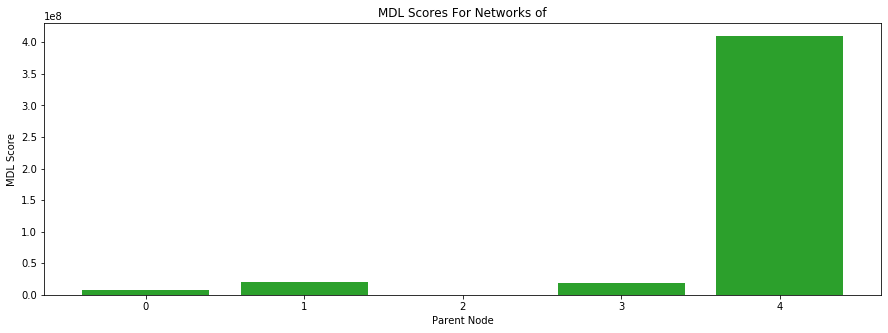

Network 0


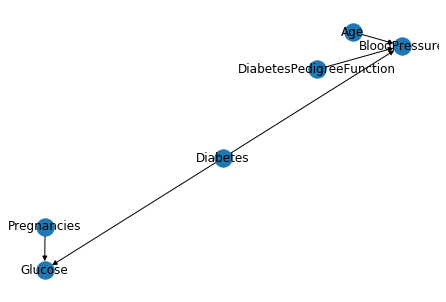

Network 1


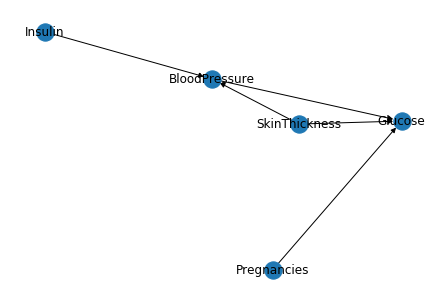

Network 2


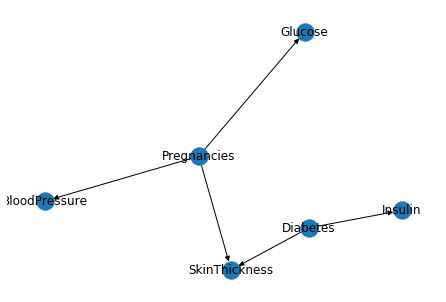

Network 3


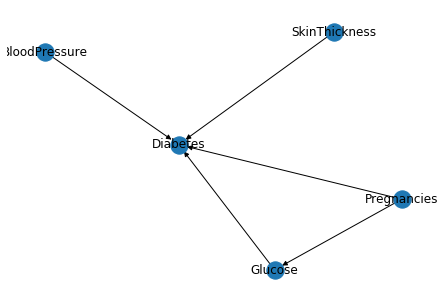

Network 4


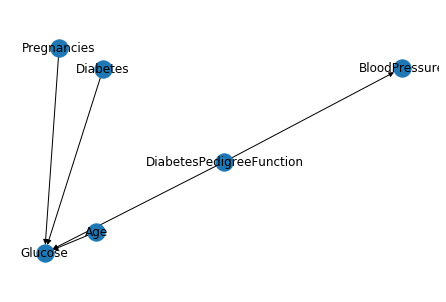

In [14]:
x = list(range(len(results2['scores'])))
y = results2['scores']

fig, axs = plt.subplots(figsize=(15,5))
plt.bar(x, y, color="tab:green")
plt.ylabel('MDL Score') 
plt.xlabel('Parent Node')
plt.title("MDL Scores For Networks of 5 edges")
plt.show()

i = 0
for n in results2['networks']:
    print("Network", i)
    n.draw()
    i += 1

<font color="blue">
From this small sample of networks, we can see that Network 4 has a significantly higher MDL score than the rest. This suggests that Network 4 models the data significantly worse than the other networks. While Networks 0 through 3 at least look like an attempt at finding relationships in the data, Network 4 falsely suggests that everything else has a direct relationship to Glucose (with the acception of Blood Pressure). Intuitively, someone would have a much easier time disporoving Network 4 rather than disproving Networks 0 through 3. Thus, this experiment gave us a macro view to show us that MDL prefers networks that model the data accurately. However, we can verify this at the micro level in the next section

# 2. MDL Score Agrees With Intuition

<font color="blue">
Perhaps, it will help us gain a better understanding of MDL if we looked at a micro level. Instead of considering the whole network let's just focus on one node. Particularly, let's look at pregnancies because they are easy for intuition purposes. 

In [28]:
scorer.local_score('Pregnancies', [])

1906.773475884517

<font color="blue">
With no parents, the Pregnancies node has an MDL score of 1906. This is the baseline for this node. The question is, how do other parents cause a change in this score?

We should be able to intuitively recognize that Age is a cause of Pregnancies. Thus, we would expect that the network `Age --> Pregnancies` should have a lower MDL relative to any other network `?--> Age`

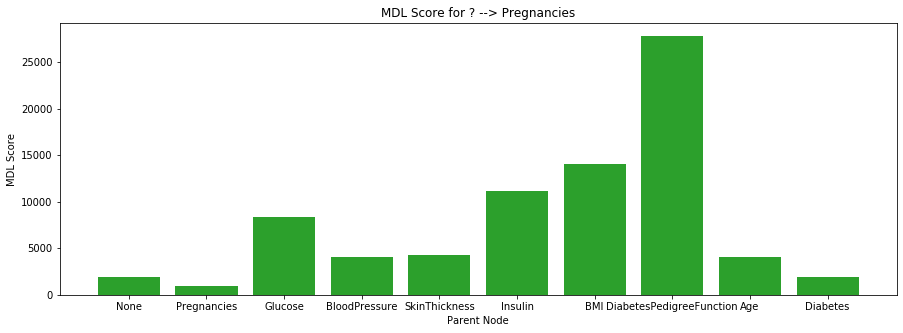

In [31]:
def which_parent(data, child_name): # add none to this
    scorer = MDL_Scorer(data)
    parents = []
    scores = []
    
    
    # No parents
    parents.append("None")
    scores.append(scorer.local_score(child_name, []))
    
    # Do the actual one
    df_2 = data.copy()
    df_2['Duplicated'] = data[child_name]
    scorer_2 = MDL_Scorer(df_2)
    parents.append(child_name)
    scores.append(scorer_2.local_score(child_name, ['Duplicated']))
    
    for i in range(len(list(data.columns))):
        node = list(data.columns)[i]
        if node != child_name:
            parents.append(node)
            scores.append(scorer.local_score(child_name, [node]))
            
    x = list(range(len(parents)))
    y = scores
    
    fig, axs = plt.subplots(figsize=(15,5))
    plt.bar(x, y, color="tab:green")
    axs.set_xticklabels(parents)
    plt.ylabel('MDL Score') 
    plt.xlabel('Parent Node')
    plt.xticks(x)
    plt.title("MDL Score for ? --> " + child_name)
    plt.show()

which_parent(diabetes, 'Pregnancies')

<font color="blue">
We see here that pregnancies has the lowest MDL score. This intuitively makes sense as pregnancies should be the best node to describe pregnancies. Ruling this out, we see that Age is one of the four best choices for a parent of pregnancies. 

There are $ {9 \choose 0} + {9 \choose 1} + ... + {9 \choose 9} $ possible combinations of parents to choose from. And this is just for one node. Thus, you cannot search the entire state space! This is where evolutionary programming comes into play. This will help us minimize the search space.

In total there are $ 2 ^ {(9 * 9)} = ~ 2 * 10 ^{24} $ possible networks. It is not feasible to search through every single network to find the one with the global minimal MDL score. Thus, we will need a different approach. This is where Evolutionary Programming comes into play.

# 3. Evolutionary Programming Using MDL

## 3.1 Pseudocode for Evolutionary Programming

<font color="blue">
What is evolutiionary programming? Essentially the basics are to...
    
1. Start with an initial population which is created randomly
1. Create a mutation on each of the individuals in the population. Mutations can be to either create an edge or to delete an edge. Mutated networks are called "offspring" while the networks that the offspring came from are called "parents".
1. Sort each network (offspring and parents) by their MDL score.
1. Cut the population in half such that the new population has the half with the lower MDL scores.
1. Repeat this process for a specified number of iterations. Each iteration is called a "generation"

<font color="blue">
Pseudocode for this process is below. My actual implementation for this can be found at 
    
`ep.py`

## 3.2 Using Diabetes Sample

<font color="blue">
Let's run an experiment on the diabetes dataset* using evolutionary programming. What insights can we gaini by comparing the generations of the network to their MDL score? 

\* Note that the program took a lot of time (10+ hours) to run on the dataset. Thus, I created a smaller sample of only 15 rows. While this is not optimal, it will be addressed later on. Additionally, there are still insights to learn even if the resulting network was not reliable

In [49]:
small_diabetes = diabetes.sample(n=15, random_state=1)

In [14]:
diabetes_results = EP(p_init=10, Gen_total=30, dataframe=small_diabetes, verbose=0)

In [4]:
def plot_ep_experiment(generations, results3, title):
    Y = list(results3[1].values())
    y_list = []
    x_list = []

    fig, axs = plt.subplots(figsize=(15,5))
    lastx = 0
    for gen in range(len(Y)):
        y = np.flip(Y[gen])
        x = range(lastx, len(y) + lastx)
        y_list += list(y)
        x_list += x
        lastx = x[-1]
        plt.scatter(x, y, color="tab:green" if gen % 2 == 0 else "tab:blue", s=75)

    plt.plot(x_list, y_list, color="black", alpha=.75)

    plt.ylabel('MDL Score') 
    plt.xlabel('Network History')
    plt.title(title)
    plt.show()
    
    gen = generations -1
    print("Most Fit Network: Score", results3[1][gen][-1])
    results3[2][gen][1].draw()
    print(results3[2][gen][1].matrix)
    print("")
    
    gen = int((generations -1) /2)
    print("Medium Network: Score", results3[1][gen][-1])
    results3[2][gen][1].draw()
    print(results3[2][gen][1].matrix)
    print("")
    
    gen = 0
    print("Worst Network: Score", results3[1][gen][-1])
    results3[2][gen][1].draw()
    print(results3[2][gen][1].matrix)
    

<font color="blue">
After plotting the data we see a sharp decline in MDL score. This does suggest that our goal of finding networks with smaller MDL scores.

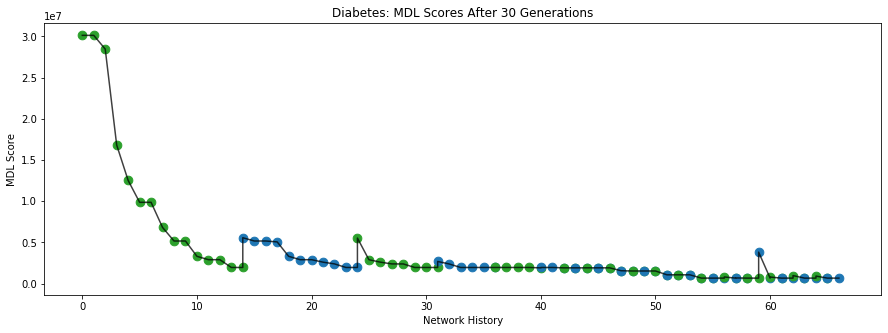

Most Fit Network: Score 664445.8755865983


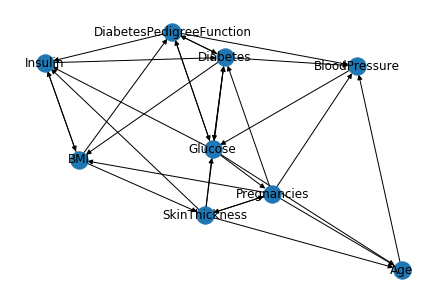

   0  1  2  3  4  5  6  7  8
0  0  0  1  1  0  1  0  1  1
1  1  0  0  0  1  0  1  1  1
2  0  1  0  0  0  0  0  0  0
3  1  1  0  0  1  0  0  1  1
4  0  0  0  0  0  1  0  0  1
5  0  0  0  1  1  0  1  0  0
6  0  1  1  0  1  0  0  0  1
7  0  0  1  0  0  0  0  0  0
8  0  1  1  0  0  1  1  0  0

Medium Network: Score 1529694.9953407655


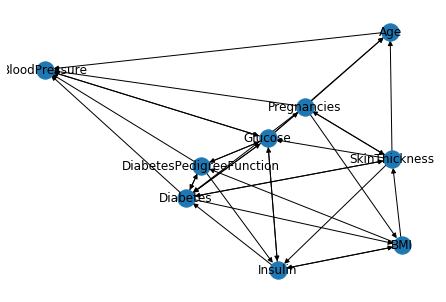

   0  1  2  3  4  5  6  7  8
0  0  0  1  1  0  1  0  1  1
1  1  0  1  0  1  0  1  1  1
2  0  1  0  0  0  0  0  0  0
3  1  1  0  0  1  0  0  1  1
4  0  1  0  0  0  1  0  0  1
5  0  0  0  1  1  0  1  0  0
6  0  1  1  0  1  0  0  0  1
7  0  0  1  0  0  0  0  0  0
8  0  1  1  1  0  1  1  0  0

Worst Network: Score 30116348.996455964


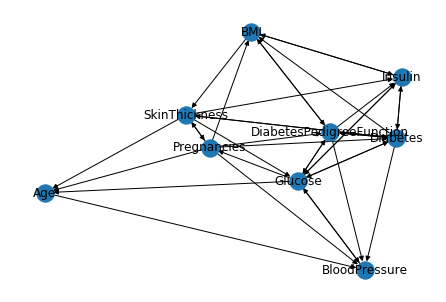

   0  1  2  3  4  5  6  7  8
0  0  0  1  1  0  1  1  1  1
1  1  0  1  0  1  0  1  1  1
2  0  1  0  0  0  0  0  0  0
3  1  1  0  0  1  0  0  1  1
4  0  1  0  0  0  1  0  0  1
5  0  0  0  1  1  0  1  0  0
6  0  1  1  0  1  1  0  0  1
7  0  0  1  0  0  0  0  0  0
8  0  1  1  1  1  1  1  0  0


In [25]:
plot_ep_experiment(generations=30, results3=diabetes_results, title="Diabetes: MDL Scores After 30 Generations")

<font color="blue">
When visually comparing the most fit network to the medium and worst networks, we see that all three networks still look too complex to interpret. While the diabetes dataset was good for teaching us about the intuition of MDL scores, we should use simpler more understandable data to learn about evolutionary programming

## 3.2 Alarm Example

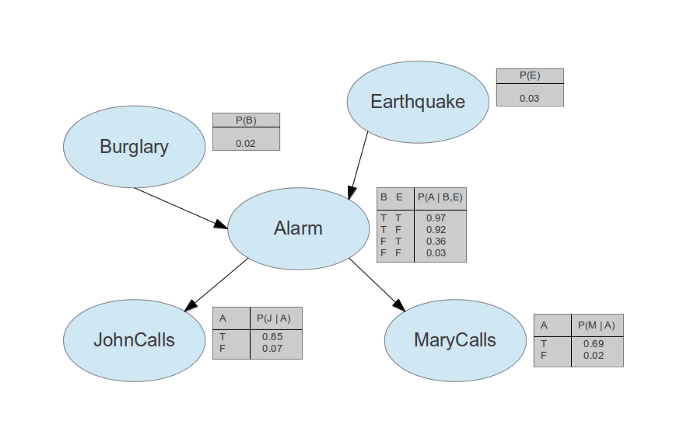

In [3]:
Image("images/example relationships.png")

<font color="blue">
For the remainder of this report, let's use the classic alarm example to study evolutionary programming. In this example, our alarm can be turned on for one of two reasons. Either there was a burglary or there was an earthquake. In the unlikely case that either of these events happen, our neighbors John and Mary have promised to call us. however, they have different levels of reliability and thus may not actually call.

<font color="blue">
We are given the probability distributions for each of these events. We can use our knowledge of conditional probability to create a joint probability distribution of the data.

<font color="blue">
    
Joint Probability
$ p(X_1, X-n) = \pi_{i=1} (X_i | Parents(X_i)) $

In [32]:
# Conditional Probabilities

p_B = {'True': 0.02,
       'False': 0.98}

p_E = {'True': 0.03,
       'False': 0.97}


p_A_given_BE = {'TrueTrueTrue': 0.97,
                'TrueTrueFalse': 0.92,
                'TrueFalseTrue': 0.36, 
                'TrueFalseFalse': 0.03, 
                'FalseTrueTrue': 0.03,
                'FalseTrueFalse': 0.08,
                'FalseFalseTrue': 0.64, 
                'FalseFalseFalse': 0.97}

p_J_given_A = {'TrueTrue': 0.85, 
               'TrueFalse': 0.07, 
               'FalseTrue': 0.15, 
               'FalseFalse': 0.93}

p_M_given_A = {'TrueTrue':0.69,
               "TrueFalse": 0.02, 
               "FalseTrue":0.31, 
               "FalseFalse": 0.98}

In [ ]:
def s(*array):
    s_ = ""
    for v in array:
        s_ += str(v)
    return s_

def joint(A, B, E, J, M):
    return p_B[s(B)] * p_E[s(E)] * p_A_given_BE[s(A, B, E)] * p_J_given_A[s(J, A)] * p_M_given_A[s(M, A)]

joint_probability_dist = {} #A, B, E, J, M

for B in [True, False]:
    for E in [True, False]:
        for A in [True, False]:
            for J in [True, False]:
                for M in [True, False]:
                    string = str(A) + " " + str(B) + " " + str(E) + " " + str(J) + " " + str(M)
                    joint_probability_dist[string] = joint(A, B, E, J, M)

<font color="blue">
We should also perform a quick reality check that the sum of the joint probabilities add up to 1

In [33]:
print(sum(list(joint_probability_dist.values())))

1.0


<font color="blue">
Let's sample from this probability distribution to get data that we can work with. We will have a sample size of 200 rows

In [34]:
num_samples = 200

draw = choice(list(joint_probability_dist.keys()), num_samples,
              p=list(joint_probability_dist.values()))

sample = draw

In [35]:
new_array = []
for row in sample:
    new_array.append(row.split(" "))
    
alarm = pd.DataFrame(new_array)
alarm.columns = ['Burglary', 'Earthquake', 'Alarm', 'John Calls', 'Mary Calls']
alarm.describe()

,Burglary,Earthquake,Alarm,John Calls,Mary Calls
count,200,200,200,200,200
unique,2,2,2,2,2
top,False,False,False,False,False
freq,186,196,193,178,185


<font color="blue">
Here is a sample of 10 rows to give us a reality check. We see that each event lines up with their probability distributions

In [42]:
alarm.sample(10)

,Burglary,Earthquake,Alarm,John Calls,Mary Calls
51,True,False,False,True,True
146,False,False,False,False,False
62,False,False,False,False,False
52,True,False,True,True,False
188,False,False,False,False,False
159,False,False,False,False,False
57,False,False,False,False,False
119,False,False,False,False,False
97,False,False,False,False,False
20,False,False,False,False,False


In [39]:
num_gen = 200
alarm_results = EP(p_init=20, Gen_total=num_gen, dataframe=alarm, verbose=0)

<font color="blue">
Next, let's run our evolutioniary programming algorithm on the new dataset.

<font color="blue">
Interestiingly, we see the same behavior as with the diabetes dataset. That is, in both cases, there was a quick decline in MDL scores followed by essentially coasting off at the same scores. This suggests that we are focusing in on a network that describes the data. Now, let's take a look at the actual network visualizations

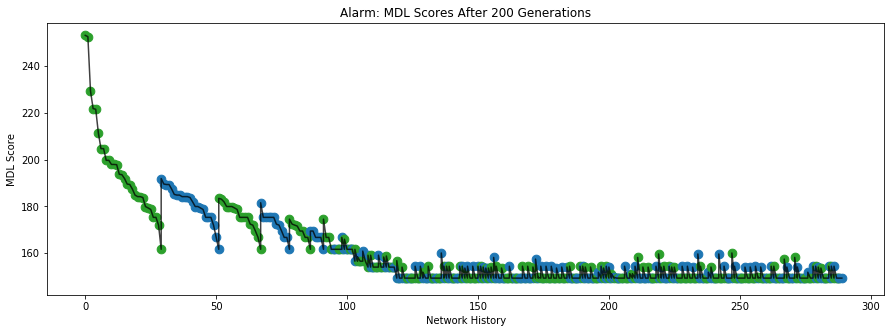

Most Fit Network: Score 149.2581755946368


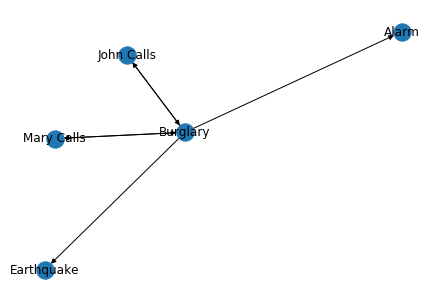

   0  1  2  3  4
0  0  1  1  1  1
1  0  0  0  0  0
2  0  0  0  0  0
3  1  0  0  0  0
4  1  0  0  0  0

Medium Network: Score 149.2581755946368


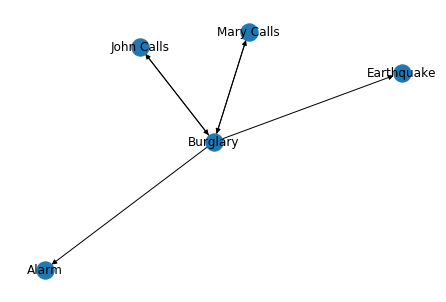

   0  1  2  3  4
0  0  1  1  1  1
1  0  0  0  0  0
2  0  0  0  0  0
3  1  0  0  0  0
4  1  0  0  0  0

Worst Network: Score 253.1942536019073


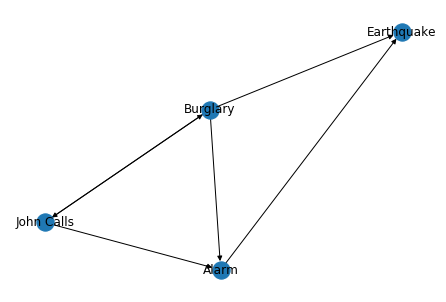

   0  1  2  3  4
0  0  1  1  1  0
1  0  0  0  0  0
2  0  1  0  0  0
3  1  0  1  0  0
4  0  0  0  0  0


In [40]:
plot_ep_experiment(generations=num_gen, results3=alarm_results, title="Alarm: MDL Scores After " + str(num_gen) + " Generations")

<font color="blue">
Interestingly, there is a significant improvement between the worst and the best networks. In the best networks, all the nodes are actually correlated to burglary, except for earthquke. The Burglary --> Earthquake edge is clearly incorrect but this is only one mutation away from a correct network. It is also interesting to notice that the network did correctly recognize that Burglary and the neighbors calling are associated yet it did not correctly recognize that this relationship is truly an indirect relationship rather than direct. 

# 4. Balance Between Diversity and Redundancy

<font color="blue">
In both evolutionary programming experiments (alarm data and diabetes data) there were some common behaviors. Essentially, the MDL score quickly decreased and then stayed relatively constant. While this may suggest that we are focusing in on the best network there are a few issues. First, the network that we are focusing in on may be good but it is likely not the best network. Secondly, since we are focusing in on one particular network we are performing redundant computations. In fact, we could even be mutating in a loop of similar networks

<font color="blue">
Rather than focusing in on one network, we should modify our algorithm to prefer diverse networks. We can do this through the following modifications

## 4.1 Theory: Adaptive Evolutionary Programming

<font color="blue">
In adaptive evolutionary programming, we will favor diversity yet reduce redundancy. While my specific implementation can be found at `aep.py` The following pseudocode is as follows: 

<font color="blue">
First, the Increasing Routine is meant to favor diversity:

<font color="blue">
The increase routine works by finding unique networks (networks that have a high average distance from all other networks). It then favors this network by keeping both it and its parent in the population. We want diversity at the begining of the evolutionary process but not at the end. We can hold this by only running the increase routine if we haven't reached a particular generation yet.

<font color="blue">
Next, the Decrease routine is meant to decrease redundancy

<font color="blue">
In the original algorithm, if the parent and child were both in the top 50% of networks then both would be kept. Yet, with the decrease routine only the child is kept. This reduces redundancy. Furthermore, in the original algoritm it is possible to have identical networks. Thus, we need to perform reduntant computations. In two there are two identical networks then we remove one of them.

## 4.2 Analysis

<font color="blue">
Finally, let's run the alarm data on our adaptive evolutionary programming algorithm and analyze the results

In [24]:
# line 97
num_gen= 50
aep_alarm_results = AEP(p_init=10,
                        p_max=30, 
                        Gen_total=num_gen, 
                        dataframe=alarm,
                        pop_threshold=.9, 
                        gen_threshold= int(num_gen/2), 
                        distance_theshold=1, 
                        verbose=0)

Running Generation 0
     increase routine
     decrease routine
Running Generation 1
     increase routine
     decrease routine
Running Generation 2
     increase routine
     decrease routine
Running Generation 3
     increase routine
     decrease routine
Running Generation 4
     increase routine
     decrease routine
Running Generation 5
     increase routine
     decrease routine
Running Generation 6
     increase routine
     decrease routine
Running Generation 7
     increase routine
     decrease routine
Running Generation 8
     increase routine
     decrease routine
Running Generation 9
     increase routine
     decrease routine
Running Generation 10
     increase routine
     decrease routine
Running Generation 11
     increase routine
     decrease routine
Running Generation 12
     increase routine
     decrease routine
Running Generation 13
     increase routine
     decrease routine
Running Generation 14
     increase routine
     decrease routine
Running Generation 1

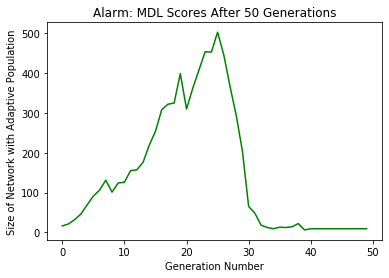

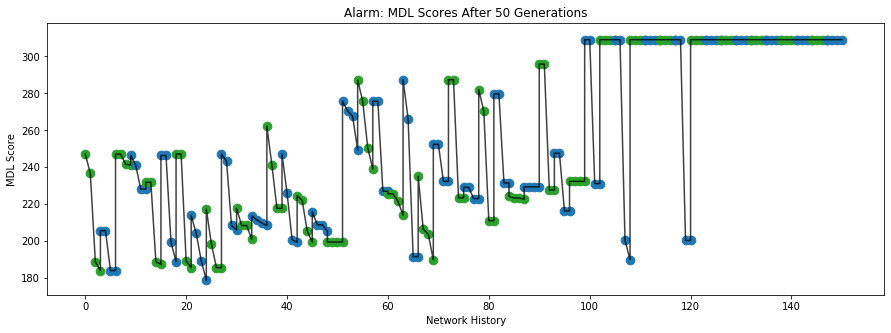

Most Fit Network: Score 309.05691664778317


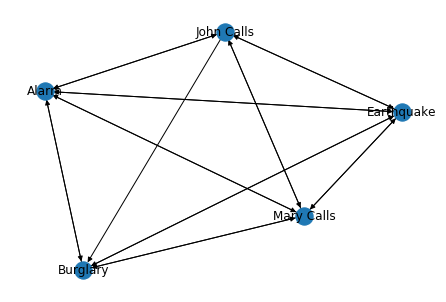

   0  1  2  3  4
0  0  1  1  0  1
1  1  0  1  1  1
2  1  1  0  1  1
3  1  1  1  0  1
4  1  1  1  1  0

Medium Network: Score 287.38738767401793


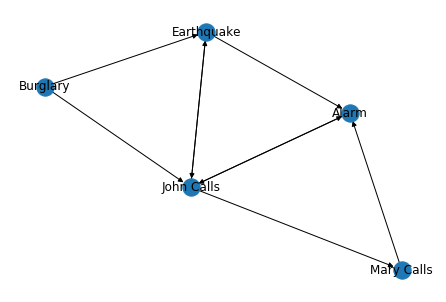

   0  1  2  3  4
0  0  1  0  1  0
1  0  0  1  1  0
2  0  0  0  1  0
3  0  1  1  0  1
4  0  0  1  0  0

Worst Network: Score 247.14497527826825


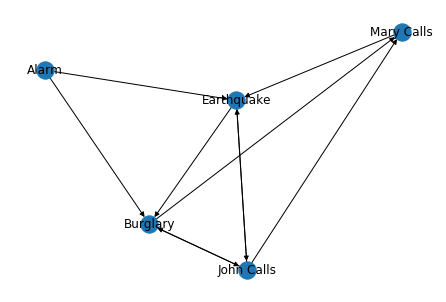

   0  1  2  3  4
0  0  0  0  1  1
1  1  0  0  1  0
2  1  1  0  0  0
3  1  1  0  0  1
4  0  1  0  0  0


In [25]:
def plot_aep_experiment(generations, results3, title):
    
    x = range(len(aep_alarm_results[3]))
    size = aep_alarm_results[3]
    
    plt.plot(x, size, color="green")
    plt.xlabel('Generation Number') 
    plt.ylabel('Size of Network with Adaptive Population')
    plt.title(title)
    plt.show()
    
    
    plot_ep_experiment(generations=generations, results3=results3, title=title)
    
plot_aep_experiment(generations=num_gen, results3=aep_alarm_results, title="Alarm: MDL Scores After " + str(num_gen) + " Generations")

<font color="blue">
What we see is that the population size did increase until we reached half the generations. Then the population size decreased. This implies that we were increasing the diversity of the population halfway. This was because in the functioni command we specified to only run the increase routine for the first half of the generations. Secondly, after the increase routine is supposed to stop the decrease routine removes any redundancy in the population. 

<font color="blue">
In regards to the MDL scores, we notice much more variablity than before. Given our constraints, this is good as it suggests that the there is a lot of diversity in the network. We also notice that the MDL scores only begin to focus in at a particular score after the halfway point in which the increase routine has stopped running. This further implies that the MDL scores were fluctuating due to the increase routine. 

<font color="blue">
We see that the best network is actually more complex than that of the normal evolutionary programming. While this may seem alarming at first, rest assured that this is actually good. While the network in the original algorithm did point toward a promising design, we agreed that it was too simplistic as it did not recognize any indirect relationships. In contrast, the most fit network of the adaptive evolutionary programming is a complete graph such that all nodes point to each other. This network is closer to our true network from section 3.2. It is actually only a few mutations off from being exactly correct. This suggests that while evolutionary programming is only set to favor lower MDL scores, the modifications in the adaptive evolutionary programming help to favor other factors as well.

# 5. Conclusion

<font color="blue">
I have been interested in evolutionary programming for a while and I appreciate the opportunity to use this project to explore my interest. Evolutionary programming with Bayesian networks requires some metric of scoring the networks. One such metric is the minimum descriptive length which takes advantage of information theory to select a simple network that has a high probability of modeling the data. Research in this field looks at the numerious selection techniques for selecting the most probable network. Among these techniques is the standard evolutionary programming which only favors networks with a low MDL score. Furthermore, adaptive evolutionary programming which adapts the size of the population to not only favor low MDL scores but also to favors high diversity and low redundancy. Adaptive evolutionary progamming may find network that is more complex than that of standard evolutionary programming. This suggests that the adaptive technique is putting less of an emphasis on simplicity and more of an emphasis on finding the a more suitable network, even if it is slightly more complex.
    
Future work could be to implement other evolutionary programming modifications as well as modify the number of generations and the thresholds of the current algorithms.